# Judul Topik : Deteksi Kebakaran Menggunakan Model Deep Learning dan Ekstraksi Fitur Bottleneck Xception

Nama        : Feby Akliji Rofiah
NIM         : A11.2022.14529
Kelas       : A11.4419
Matkul      : Pembelajaran Mesin

## 1. Ringkasan dan Permasalahan

Kebakaran adalah bencana yang sering terjadi dan dapat menyebabkan kerugian besar baik material maupun non-material. Deteksi dini kebakaran sangat penting untuk mengurangi dampak negatif tersebut. Dalam proyek ini, kami mengembangkan model deep learning untuk mendeteksi kebakaran dari gambar menggunakan ekstraksi fitur bottleneck dari model Xception yang telah dilatih sebelumnya.

Permasalahan utama yang dihadapi adalah bagaimana membangun dan mengimplementasikan model deteksi kebakaran yang efisien dan efektif menggunakan menggunakan model deep learning dan ekstraksi fitur bottleneck Xception untuk meningkatkan respons dan mitigasi kebakaran


## 2. Model atau Alur Penyelesaian

1.	Preprocessing data: Melakukan segmentasi dan penajaman gambar.
2.	Ekstraksi fitur: Menggunakan model Xception yang telah dilatih sebelumnya untuk mengekstraksi fitur bottleneck dari gambar.
3.	Modelling: Menggunakan model Sequential dari Keras untuk mengklasifikasikan gambar sebagai "kebakaran" atau "non-kebakaran".
4.	Evaluasi: Menggunakan metrik seperti akurasi, confusion matrix, dan classification report untuk mengevaluasi kinerja model. 

## 3. Penjelasan Dataset

Dataset yang digunakan dalam proyek ini terdiri dari dua kategori gambar:
•	Gambar yang mengandung kebakaran (fire_images)
•	Gambar yang tidak mengandung kebakaran (non_fire_images)
Total dataset berisi 999 gambar, dengan 755 gambar kebakaran dan 244 gambar non-kebakaran.


In [1]:
#---------------------Import Libraries---------------------

# numpy, pandas, matplotlib, seaborn: Digunakan untuk manipulasi data, analisis, dan visualisasi.
# keras.applications.xception: Untuk menggunakan model Xception yang sudah dilatih sebelumnya.
# sklearn: Untuk evaluasi dan split data.
# cv2: OpenCV untuk manipulasi gambar.
# tqdm: Progress bar untuk looping.
# glob: Untuk membaca file.
# keras.models, keras.layers: Untuk membangun model deep learning.

import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

import os
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import cv2
from scipy.stats import uniform

from tqdm import tqdm
from glob import glob

from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking
from keras.utils import to_categorical

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



In [2]:
#---------------------Mengumpulkan Data---------------------

#Menentukan folder yang menyimpan dataset.
base_folder = 'input/fire_dataset'
data_folder = 'input/fire_dataset'
train_data_folder = 'input/fire_dataset/fire_images'
test_date_folder  = 'input/fire_dataset/non_fire_images'

#Mengumpulkan data gambar
categories = ['fire_images', 'non_fire_images']
len_categories = len(categories)

In [3]:
#Menghitung jumlah gambar dalam setiap kategori.
image_count = {}
train_data = []

for i , category in tqdm(enumerate(categories)):
    class_folder = os.path.join(data_folder, category)
    label = category
    image_count[category] = []
    
    for path in os.listdir(os.path.join(class_folder)):
        image_count[category].append(category)
        train_data.append(['{}/{}'.format(category, path), i, category])

2it [00:00, 553.70it/s]


In [4]:
#---------------------Menampilkan Informasi Dataset---------------------

#Menampilkan jumlah gambar dalam setiap kategori.
for key, value in image_count.items():
    print('{0} -> {1}'.format(key, len(value)))

fire_images -> 755
non_fire_images -> 244


In [5]:
#Membuat DataFrame dari data yang dikumpulkan untuk mempermudah manipulasi dan analisis.
df = pd.DataFrame(train_data, columns=['file', 'id', 'label'])
df.shape
df.head()

(999, 3)

,file,id,label
0,fire_images/fire.1.png,0,fire_images
1,fire_images/fire.10.png,0,fire_images
2,fire_images/fire.100.png,0,fire_images
3,fire_images/fire.101.png,0,fire_images
4,fire_images/fire.102.png,0,fire_images


## 4. Proses Learning atau Modelling:

In [6]:
#---------------------Preprocessing Gambar---------------------

#masking function: Membuat mask untuk bagian yang diinginkan dari gambar.
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

#image segmentation function: Melakukan segmentasi gambar menggunakan mask.
def segment_image(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#sharpen the image : Menajamkan gambar.
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

# function to get an image: Membaca gambar dan mengubahnya menjadi array.
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_folder, filepath), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img


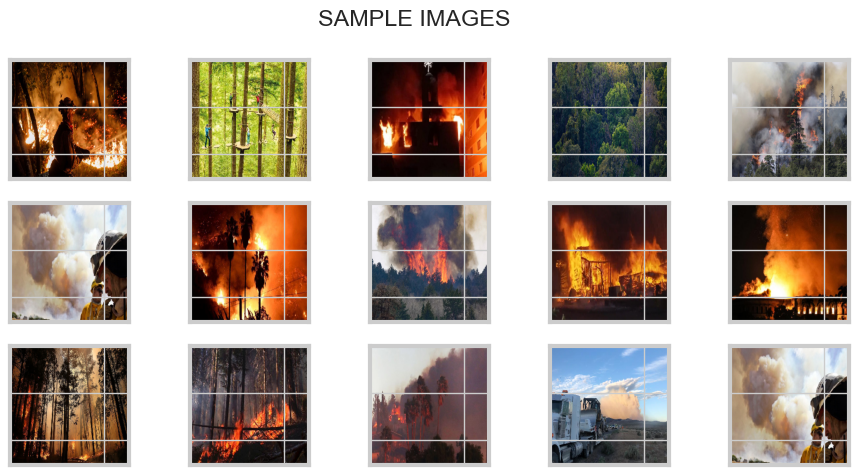

In [7]:
#---------------------Menampilkan Gambar Contoh---------------------

# Menampilkan beberapa gambar contoh dari dataset.
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5));
plt.suptitle('SAMPLE IMAGES');
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([]);
        axs[i, j].yaxis.set_ticklabels([]);
        axs[i, j].imshow((read_img(df['file'][np.random.randint(1000)], (255,255)))/255.);
plt.show();

## Proses EDA dan Features Dataset:

EDA dilakukan untuk memahami distribusi data dan mempersiapkan gambar untuk pemrosesan lebih lanjut. Gambar dalam dataset diubah menjadi array dan disegmentasi menggunakan teknik masking. Setelah itu, gambar ditajamkan untuk meningkatkan kualitas fitur visual yang penting.

Text(0.5, 1.05, 'SAMPLE PROCESSED IMAGE')

Text(0.5, 1.0, 'ORIG.')

Text(0.5, 1.0, 'MASK')

Text(0.5, 1.0, 'SEGMENTED')

Text(0.5, 1.0, 'SHARPEN')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


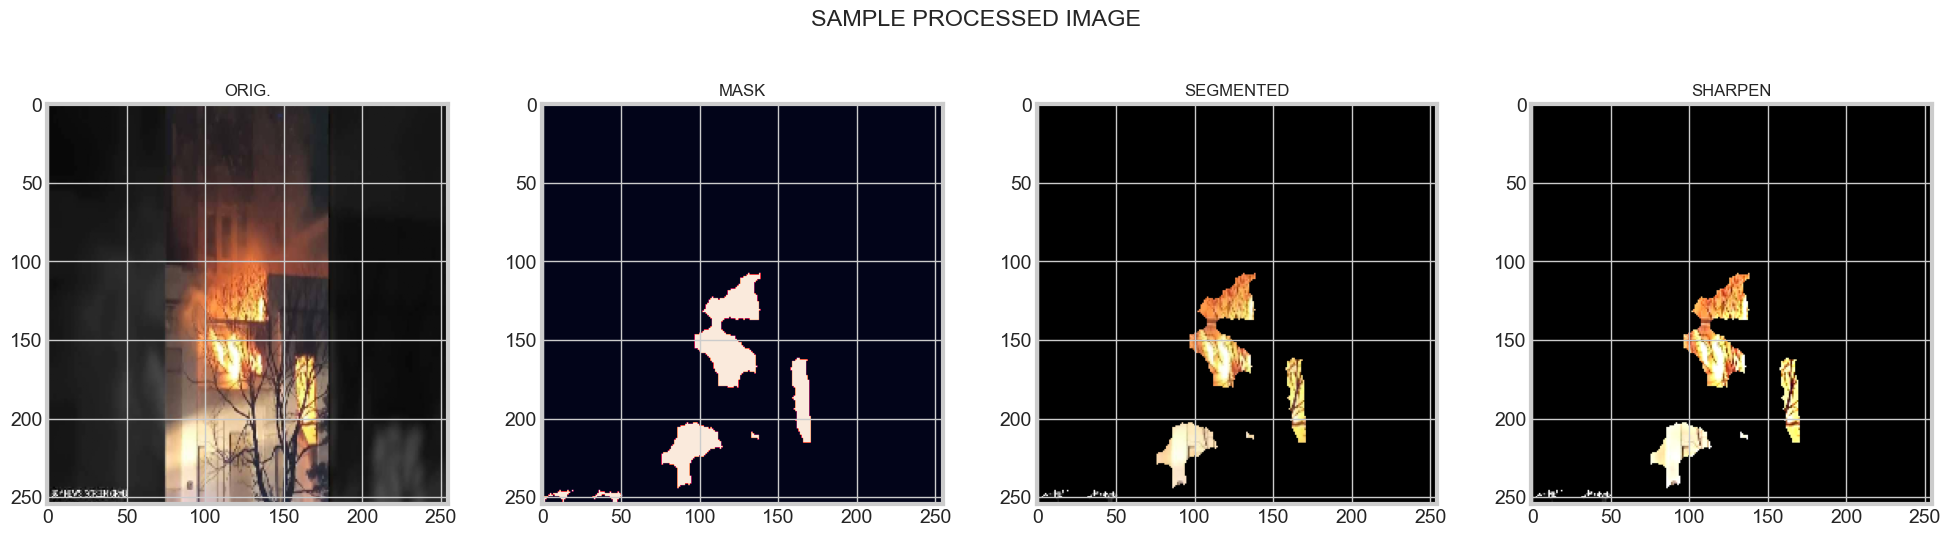

In [8]:

#---------------------Menampilkan Gambar yang Diproses---------------------

# Mengambil gambar
img = read_img(df['file'][102], (255, 255))
# Membuat mask
image_mask = create_mask_for_plant(img)
# Segmentasi
image_segmented = segment_image(img)
# Menajamkan gambar
image_sharpen = sharpen_image(image_segmented)

fig, ax = plt.subplots(1, 4, figsize=(20, 5))  # Sesuaikan figsize jika perlu
plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=1.05)  # Mengatur judul utama

# Mengatur judul untuk setiap subplot
ax[0].set_title('ORIG.', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[2].set_title('SEGMENTED', fontsize=12)
ax[3].set_title('SHARPEN', fontsize=12)

# Menampilkan gambar pada setiap subplot
ax[0].imshow(img / 255)
ax[1].imshow(image_mask)
ax[2].imshow(image_segmented)
ax[3].imshow(image_sharpen)

plt.tight_layout()  # Memastikan tata letak tidak tumpang tindih
plt.show()


In [9]:
#---------------------Ekstraksi Fitur dengan Xception---------------------

#Ekstraksi fitur dari gambar menggunakan model Xception yang sudah dilatih sebelumnya.
INPUT_SIZE=255

#preprocess input
X_train = np.zeros((len(df), INPUT_SIZE, INPUT_SIZE, df.shape[1]), dtype='float')
for i, file in tqdm(enumerate(df['file'])):
    #baca gambar
    img = read_img(file,(INPUT_SIZE,INPUT_SIZE))
    #masking dan segmentation
    image_segmented = segment_image(img)
    #sharpen(menajamkan)
    image_sharpen = sharpen_image(image_segmented)
    x = xception.preprocess_input(np.expand_dims(image_sharpen.copy(), axis=0))
    X_train[i] = x
    
print('Train Image Shape: ', X_train.shape)
print('Train Image Size: ', X_train.size)

999it [00:55, 18.12it/s]

Train Image Shape:  (999, 255, 255, 3)
Train Image Size:  194879925


In [10]:
#---------------------Split data---------------------

#Split data menjadi training dan validation set.
y = df['id']
train_x, train_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=101)

print('FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==0].shape[0])
print('NON-FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==1].shape[0])

FIRE IMAGES ON TRAINING DATA:  610
NON-FIRE IMAGES ON TRAINING DATA:  189


## Ekstraksi Fitur Bottleneck

Ekstraksi fitur dilakukan menggunakan model Xception yang telah dilatih sebelumnya. Gambar yang telah diproses (disegmentasi dan ditajamkan) diubah menjadi fitur bottleneck yang kemudian digunakan sebagai input untuk model klasifikasi.

In [11]:
#Menggunakan Model Xception Pre-trained untuk Ekstraksi Fitur
xception_bf = xception.Xception(weights='imagenet', include_top=False, pooling='avg')

#Menghasilkan Bottleneck Features
bf_train_x = xception_bf.predict(train_x, batch_size=32, verbose=1)
bf_train_val = xception_bf.predict(train_val, batch_size=32, verbose=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 324s 13s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 73s 10s/step


In [12]:
#print bentuk feature dan ukuran
print('Train Shape: ', bf_train_x.shape)
print('Train Size: ', bf_train_x.size)

print('Validation Shape: ', bf_train_val.shape)
print('Validation Size: ', bf_train_val.size)

Train Shape:  (799, 2048)
Train Size:  1636352
Validation Shape:  (200, 2048)
Validation Size:  409600


## Model Deep Learning

Model klasifikasi dibuat menggunakan arsitektur Sequential dari Keras. Model ini terdiri dari beberapa lapisan Dense dengan aktivasi ReLU dan satu lapisan output dengan aktivasi sigmoid untuk klasifikasi biner.

In [13]:
#---------------------Model Deep Learning---------------------

#keras Sequential model
model = Sequential()
model.add(Dense(units = 256 , activation = 'relu', input_dim=bf_train_x.shape[1]))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

c:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 541,057 (2.06 MB)

 Trainable params: 541,057 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

## Pelatihan Model

In [14]:
#Model dilatih selama 100 epoch dengan batch size 32
history = model.fit(bf_train_x, y_train, epochs=100, batch_size=32);

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7286 - loss: 0.5699
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7665 - loss: 0.5080
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7606 - loss: 0.4632
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7929 - loss: 0.4272
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8647 - loss: 0.3607
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8526 - loss: 0.3478
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8712 - loss: 0.3064
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8663 - loss: 0.2863
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8918 - loss: 0.2667
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8799 - loss: 0.2705
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8878 - loss: 0.2511
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy:

## 5. Uji Performa Model

Evaluasi Model:
Model dievaluasi menggunakan data validasi untuk menghitung akurasi dan membuat confusion matrix serta classification report. Hasil evaluasi menunjukkan kinerja model dalam mengklasifikasikan gambar sebagai kebakaran atau non-kebakaran.

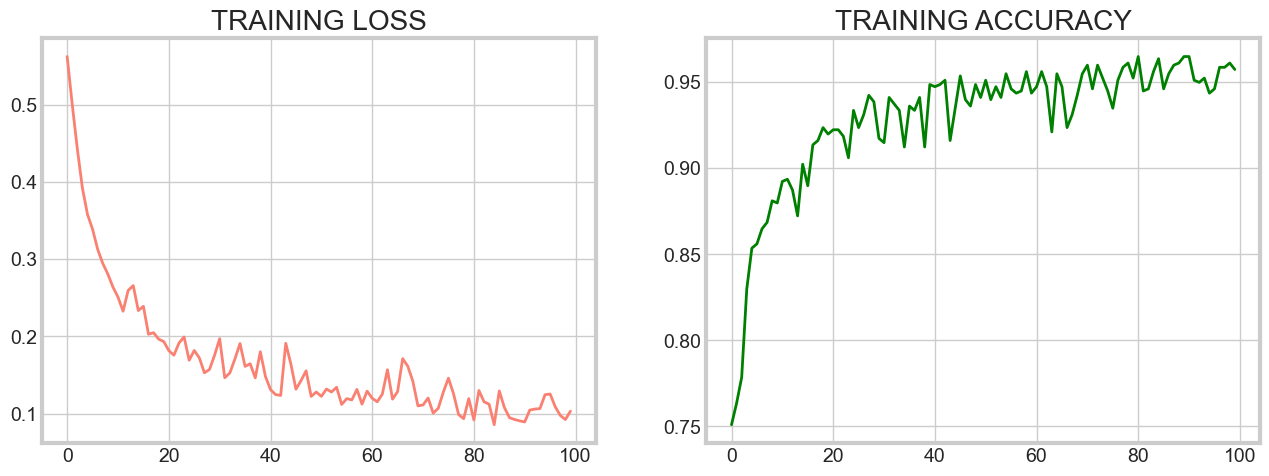

In [15]:
#---------------------LOSS AND ACCURACY---------------------

fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('TRAINING LOSS');
ax[1].set_title('TRAINING ACCURACY');


ax[0].plot(history.history['loss'], color= 'salmon',lw=2);
ax[1].plot(history.history['accuracy'], color= 'green',lw=2);

In [16]:
# Prediksi probabilitas untuk data validasi
predictions_prob = model.predict(bf_train_val)

# Ubah probabilitas menjadi kelas (0 atau 1)
# Asumsi threshold 0.5 untuk klasifikasi biner
predictions = (predictions_prob > 0.5).astype(int).flatten()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [17]:
#---------------------CLASSIFICATION REPORT---------------------

print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       145
           1       0.74      0.93      0.82        55

    accuracy                           0.89       200
   macro avg       0.85      0.90      0.87       200
weighted avg       0.91      0.89      0.89       200



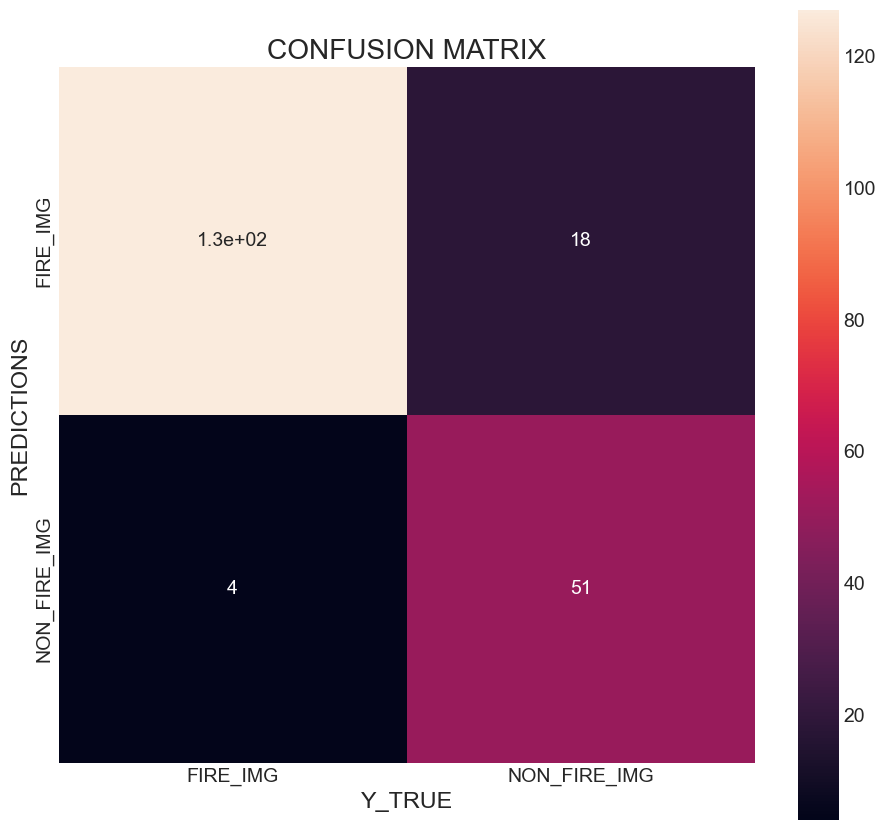

In [18]:
#---------------------CONFUSION MATRIX---------------------

confusion_mat = confusion_matrix(y_val, predictions)

plt.figure(figsize=(10,10))
sns.heatmap(confusion_mat, square=True, annot=True,
            yticklabels=['FIRE_IMG', 'NON_FIRE_IMG'],
            xticklabels=['FIRE_IMG', 'NON_FIRE_IMG']);
plt.title('CONFUSION MATRIX');
plt.xlabel('Y_TRUE');
plt.ylabel("PREDICTIONS");

Hasil Evaluasi:
Akurasi pelatihan: -

## 6. Kesimpulan

Hasil Akhir:
-

Kesimpulan:
-